In [1]:
import glob
from skimage import io
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torchvision.transforms.functional as TF
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import random

from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import KFold


import sys
sys.path.insert(0, './code')
from evaluation import *
from training import *


import numpy as np
torch.manual_seed(1)
torch.cuda.manual_seed(1)
random.seed(1)
np.random.seed(2)

import pixiedust; 
# %%pixie_debugger

def set_seed(seed): 
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.RandomState(seed)
    torch.backends.cudnn.deterministic=True

Pixiedust database opened successfully


# Constants

In [2]:
idx2label = ["Bedroom", "Highway", "Kitchen", "Office", "Street", 
                        "Coast", "Industrial", "LivingRoom", "OpenCountry", "Suburb", 
                        "Forest", "InsideCity", "Mountain", "Store", "TallBuilding"]
classNames = idx2label

label2idx = {}
for i, label in enumerate(idx2label): 
    label2idx[label] = i 
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

SEED = 1
# %%pixie_debugger

cuda:0


# Parameters and settings

In [3]:
assert torch.cuda.is_available()

print_every = 1
num_epoch = 100
K = 6
train_batch_size = 50
test_batch_size = 50
input_size = 124

# Architecture

In [4]:
# Simple CNN
class SimpleNet(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        base_size = 8
        
        self.base_size = base_size
        self.pool1_size = 2
        self.pool2_size = 3
        self.conv1_size = 5
        self.conv2_size = 5
        self.conv3_size = 5
        self.conv1_channel = 10
        self.conv2_channel = 20
        self.conv3_channel = 5
        
        self.hd1 = 32
        self.od = 15
        
        
        self.conv1 = nn.Conv2d(1, self.conv1_channel, self.conv1_size)
        self.conv2 = nn.Conv2d(self.conv1_channel, self.conv2_channel, self.conv2_size)
        self.pool1 = nn.MaxPool2d(self.pool1_size, self.pool1_size)
        
        self.bn2d1 = nn.BatchNorm2d(self.conv1_channel)
        self.bn2d2 = nn.BatchNorm2d(self.conv2_channel)
        
        self.conv3 = nn.Conv2d(self.conv2_channel, self.conv3_channel, self.conv3_size)
        self.pool2 = nn.MaxPool2d(self.pool2_size, self.pool2_size)
        self.bn2d3 = nn.BatchNorm2d(self.conv3_channel)
        
        
        self.bn1 = nn.BatchNorm1d(self.conv3_channel*self.base_size*self.base_size)
        self.fc1 = nn.Linear(self.conv3_channel*self.base_size*self.base_size, self.hd1)
        self.bn2 = nn.BatchNorm1d(self.hd1)
        self.fc2 = nn.Linear(self.hd1, self.od)
        
        before_conv3_size = self.base_size*self.pool2_size + self.conv3_size - 1
        before_conv2_size = before_conv3_size*self.pool1_size + self.conv2_size - 1
        self.input_size = before_conv2_size*self.pool1_size + self.conv1_size - 1
        
        print("input_size = %d" %(self.input_size))

    def forward(self, x):
        x = self.pool1(torch.tanh(self.conv1(x)))
        x = self.bn2d1(x)
        x = self.pool1(torch.tanh(self.conv2(x)))
        x = self.bn2d2(x)
        x = self.pool2(torch.tanh(self.conv3(x))) 
        x = self.bn2d3(x)
        x = x.view(-1, self.conv3_channel*self.base_size*self.base_size) # base_size x base_size
        x = self.bn1(x)
        x = torch.tanh(self.fc1(x))
        x = self.bn2(x)
        x = self.fc2(x)
        return x

# VGG
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        depth1 = 2
        depth2 = depth1*2
        depth3 = depth2*2
        depth_out = 4

        # input size: 1 x 124 x 124 

        # 4 * 3 * 3 = 36 
        self.conv11 = nn.Conv2d(1, depth1, 3) # size - 2, 122
        self.bn11 = nn.BatchNorm2d(depth1) 

        # 4 * 3 * 3 * 4 = 144
        self.conv12 = nn.Conv2d(depth1, depth1, 3) # size - 2, 120
        self.bn12 = nn.BatchNorm2d(depth1)
        self.pool1 = nn.MaxPool2d(2, 2) # floor(size/2), 60

        # 4 * 3 * 3 * 8 = 288
        self.conv21 = nn.Conv2d(depth1, depth2, 3) # size - 2, 58
        self.bn21 = nn.BatchNorm2d(depth2)

        # 8 * 3 * 3 * 8 = 576
        self.conv22 = nn.Conv2d(depth2, depth2, 3) # size - 2, 56
        self.bn22 = nn.BatchNorm2d(depth2)
        self.pool2 = nn.MaxPool2d(2, 2) # floor(size/2), 28

        # 8 * 3 * 3 * 16 = 1152
        self.conv31 = nn.Conv2d(depth2, depth3, 3) # size - 2, 26
        self.bn31 = nn.BatchNorm2d(depth3)

        # 16 * 3 * 3 * 16 = 2304
        self.conv32 = nn.Conv2d(depth3, depth3, 3) # size - 2, 24
        self.bn32 = nn.BatchNorm2d(depth3)
        self.pool3 = nn.MaxPool2d(2, 2)  # floor(size/2), 12
        
        # output convolution layer
        self.convo = nn.Conv2d(depth3, depth_out, 1)
        self.bno = nn.BatchNorm2d(depth_out)
        

        self.hd0 = depth_out * 12 * 12 
        self.hd1 = 12 * 12
        self.hd2 = 50

        # 16*12*12 * 4*12*12 = 1327104
        self.fc1 = nn.Linear(self.hd0, self.hd1)
        self.bn_fc1 = nn.BatchNorm1d(self.hd1)

        # 4*12*12 * 4*12*12 = 331776 ? smaller
        self.fc2 = nn.Linear(self.hd1, self.hd2)
        self.bn_fc2 = nn.BatchNorm1d(self.hd2)

        # 4*12*12 * 15 = 8640
        self.out = nn.Linear(self.hd2, 15)

        self.act = torch.tanh


    def forward(self, x):

        x = self.bn11(self.act(self.conv11(x)))
        x = self.bn12(self.act(self.conv12(x)))
        x = self.pool1(x)

        x = self.bn21(self.act(self.conv21(x)))
        x = self.bn22(self.act(self.conv22(x)))
        x = self.pool2(x)

        x = self.bn31(self.act(self.conv31(x)))
        x = self.bn32(self.act(self.conv32(x)))
        x = self.pool3(x)
        
        x = self.bno(self.act(self.convo(x)))

        x = x.view(-1, self.hd0)
        x = self.bn_fc1(self.act(self.fc1(x)))
        x = self.bn_fc2(self.act(self.fc2(x)))
        x = self.out(x)

        return x

    
# ResNet
class ResNetCell(nn.Module):
    def __init__(self, size):
        super(ResNetCell, self).__init__()

        self.size = size
        self.conv1 = nn.Conv2d(self.size, self.size, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(self.size)
        self.conv2 = nn.Conv2d(self.size, self.size, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(self.size)
        self.act = torch.tanh
        

    def forward(self, x):
        x_original = x.clone()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.bn2(x)
        return x + x_original
    
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        cell_size1 = 4
        cell_size2 = cell_size1*2
        cell_size3 = cell_size2*2
        
        self.conv0 = nn.Conv2d(1, cell_size1, 7, stride=2) # (124 - 7)/2 + 1 = 59
        self.act = torch.tanh
        self.pool = nn.MaxPool2d(2, 2) # 59/2 = 29 
        
        self.cell11 = ResNetCell(cell_size1)
        self.cell12 = ResNetCell(cell_size1)
        self.cell13 = ResNetCell(cell_size1)
        
        self.conv_center1 = nn.Conv2d(cell_size1, cell_size2, 1)
        
        
        self.cell21 = ResNetCell(cell_size2)
        self.cell22 = ResNetCell(cell_size2)
        self.cell23 = ResNetCell(cell_size2)
        
        self.conv_center2 = nn.Conv2d(cell_size2, cell_size3, 1)
        
        self.cell31 = ResNetCell(cell_size3)
        self.cell32 = ResNetCell(cell_size3)
        self.cell33 = ResNetCell(cell_size3)
        
        depth_out = 4
        
        self.pool = nn.MaxPool2d(2, 2) 
        self.convo = nn.Conv2d(cell_size3, depth_out, 1)
        self.hd = 4*3*3; 
        self.fc = nn.Linear(self.hd, 15)
    def forward(self, x):
        x = self.pool(self.conv0(x)) # 8 x 29 x 29 
        x = self.cell11(x)
        x = self.cell12(x) 
        x = self.cell13(x) # 4 x 29 x 29 
        x = self.pool(x) # 4 x 14 x 14
        
        x = self.conv_center1(x)
        x = self.act(x)
        x = self.cell21(x) # 8 x 14 x 14 
        x = self.cell22(x)  
        x = self.cell23(x) 
        x = self.pool(x) # 8 x 7 x 7 
        
        x = self.conv_center2(x)
        x = self.act(x)
        x = self.cell31(x) # 8 x 7 x 7 
        x = self.cell32(x)  
        x = self.cell33(x) 
        x = self.pool(x) # 8 x 3 x 3 
        
        x = self.convo(x) # 8 x 3 x 3
        x = x.view(-1, self.hd) 
        x = self.fc(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
net = Net()
print(net)
print("Total parameters = %d" % sum(p.numel() for p in net.parameters()))
print("Trainable parameters = %d" % sum(p.numel() for p in net.parameters() if p.requires_grad))

Net(
  (conv0): Conv2d(1, 4, kernel_size=(7, 7), stride=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cell11): ResNetCell(
    (conv1): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cell12): ResNetCell(
    (conv1): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cell13): ResNetCell(
    (conv1): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(4, 

# Dataset

In [6]:
set_seed(SEED)
class SceneDataset(Dataset):
    def __init__(self, X_p, y, transform=None):
        self.transform = transform
        self.X_p = X_p
        self.y = y

    def __len__(self):
        return len(self.X_p)

    def __getitem__(self, idx):
        image = Image.open(self.X_p[idx]).convert('RGB')
        image = self.transform(image)
        
        return (image, self.y[idx])
    
    def show_item(self, idx): 
        item = self[idx]
        image = TF.to_pil_image(item[0])
        plt.imshow(image)
        plt.xlabel(classNames[item[1]])
        return image

train_tf = transforms.Compose([
     transforms.Resize(200),
     transforms.Grayscale(num_output_channels=1),
     transforms.RandomHorizontalFlip(),
     transforms.RandomCrop((input_size, input_size)), 
     transforms.ToTensor(),  
     transforms.Normalize(
         mean=[0.5, 0.5, 0.5],
         std=[0.2, 0.2, 0.2])
])


test_tf = transforms.Compose([
    transforms.Resize(200),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomCrop((input_size, input_size)), 
    transforms.ToTensor(),    
    transforms.Normalize(
         mean=[0.5, 0.5, 0.5],
         std=[0.2, 0.2, 0.2])
])

def shuffle_list_pairs(a, b):
    combined = list(zip(a, b))
    random.shuffle(combined)
    a[:], b[:] = zip(*combined)

X_train_p = glob.glob("hw5/images/train/*/*")
y_train = [label2idx[s[17:].split("/")[0]] for s in X_train_p]

X_test_p = glob.glob("hw5/images/test/*/*")
y_test = [label2idx[s[16:].split("/")[0]] for s in X_test_p]

shuffle_list_pairs(X_train_p, y_train)
shuffle_list_pairs(X_test_p, y_test)

print("Train size = %d, test size = %d" %(len(X_train_p), len(X_test_p)))
print("Sampled Train Labels: ")
print(y_train[:10])
print("Sampled Test Labels: ")
print(y_test[:10])

Train size = 1500, test size = 2985
Sampled Train Labels: 
[7, 5, 7, 0, 1, 14, 10, 14, 8, 5]
Sampled Test Labels: 
[13, 4, 11, 10, 9, 3, 4, 9, 9, 13]


# Cross-Validation

In [7]:
set_seed(SEED)

In [8]:
# %%pixie_debugger
def predict(net, dataloader, device): 
    y_hat = torch.LongTensor([])
    y_true = torch.LongTensor([])
    
    net.eval()
    for i, batch in enumerate(dataloader):     
        images, labels = batch
        images = images.to(device)
        labels = labels.to("cpu")

        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
    
        predicted = predicted.to("cpu")

        y_true = torch.cat((y_true, labels), 0)
        y_hat = torch.cat((y_hat, predicted), 0)
    
    return (y_true, y_hat)

def evaluate(net, dataloader, classNames, device): 
    y_true, y_hat = predict(net, dataloader, device)
    return float((y_hat == y_true).sum())/len(y_true)

def cross_validate(X_train_p, y_train, n_splits, device, \
                   num_epoch, print_every, train_batch_size, test_batch_size):
    STOP_K = 6
    kf = KFold(n_splits=n_splits)
    k=0
    total_acc = 0.0 # total accuracy
    vec_acc = []
    loss_vectors = []
    for train_idx, test_idx in kf.split(X_train_p):
        k += 1
        print("[train %d/test %d]" %(len(train_idx), len(test_idx)))
        
        train_data = SceneDataset([X_train_p[i] for i in train_idx], [y_train[i] for i in train_idx], \
                                  transform=train_tf)
        test_data = SceneDataset([X_train_p[i] for i in test_idx], [y_train[i] for i in test_idx], \
                                 transform=test_tf)

        trainloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True, num_workers=4)
        testloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=True, num_workers=4)
        
        net = Net()
        net.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.01)
        
        pbar = tqdm(range(1, num_epoch+1))
        loss_vec = train(net, criterion, optimizer, trainloader, device, num_epoch, print_every, pbar)
        loss_vectors.append(loss_vec)
        
        acc = evaluate(net, testloader, classNames, device)
        
        total_acc += acc # sum up accuracy for the fold 
        print("\n\nFold-%d accuracy = %.2f" %(k, acc))
        
        vec_acc.append(acc)
        
        if k >= STOP_K: 
            break
            
#     final_acc = total_acc/k
    return (vec_acc, loss_vectors)

vec_acc, loss_vectors = cross_validate(X_train_p, y_train, K, device,\
                           num_epoch, print_every, train_batch_size, test_batch_size)


[train 1250/test 250]


[1/100] Loss = 2.61
[2/100] Loss = 2.45
[3/100] Loss = 2.34
[4/100] Loss = 2.21
[5/100] Loss = 2.13
[6/100] Loss = 2.09
[7/100] Loss = 2.04
[8/100] Loss = 1.97
[9/100] Loss = 2.03
[10/100] Loss = 1.91
[11/100] Loss = 1.84
[12/100] Loss = 1.86
[13/100] Loss = 1.79
[14/100] Loss = 1.83
[15/100] Loss = 1.80
[16/100] Loss = 1.69
[17/100] Loss = 1.78
[18/100] Loss = 1.69
[19/100] Loss = 1.64
[20/100] Loss = 1.68
[21/100] Loss = 1.60
[22/100] Loss = 1.62
[23/100] Loss = 1.66
[24/100] Loss = 1.67
[25/100] Loss = 1.66
[26/100] Loss = 1.59
[27/100] Loss = 1.56
[28/100] Loss = 1.60
[29/100] Loss = 1.62
[30/100] Loss = 1.59
[31/100] Loss = 1.58
[32/100] Loss = 1.56
[33/100] Loss = 1.56
[34/100] Loss = 1.55
[35/100] Loss = 1.55
[36/100] Loss = 1.54
[37/100] Loss = 1.59
[38/100] Loss = 1.58
[39/100] Loss = 1.52
[40/100] Loss = 1.52
[41/100] Loss = 1.53
[42/100] Loss = 1.53
[43/100] Loss = 1.49
[44/100] Loss = 1.55
[45/100] Loss = 1.54
[46/100] Loss = 1.44
[47/100] Loss = 1.51
[48/100] Loss = 1.50
[

[1/100] Loss = 2.64
[2/100] Loss = 2.46
[3/100] Loss = 2.34
[4/100] Loss = 2.26
[5/100] Loss = 2.16
[6/100] Loss = 2.17
[7/100] Loss = 2.10
[8/100] Loss = 1.96
[9/100] Loss = 1.95
[10/100] Loss = 1.85
[11/100] Loss = 1.81
[12/100] Loss = 1.80
[13/100] Loss = 1.79
[14/100] Loss = 1.75
[15/100] Loss = 1.76
[16/100] Loss = 1.76
[17/100] Loss = 1.70
[18/100] Loss = 1.69
[19/100] Loss = 1.67
[20/100] Loss = 1.66
[21/100] Loss = 1.67
[22/100] Loss = 1.65
[23/100] Loss = 1.67
[24/100] Loss = 1.63
[25/100] Loss = 1.59
[26/100] Loss = 1.61
[27/100] Loss = 1.57
[28/100] Loss = 1.61
[29/100] Loss = 1.62
[30/100] Loss = 1.61
[31/100] Loss = 1.62
[32/100] Loss = 1.55
[33/100] Loss = 1.58
[34/100] Loss = 1.52
[35/100] Loss = 1.55
[36/100] Loss = 1.57
[37/100] Loss = 1.62
[38/100] Loss = 1.51
[39/100] Loss = 1.48
[40/100] Loss = 1.54
[41/100] Loss = 1.52
[42/100] Loss = 1.50
[43/100] Loss = 1.48
[44/100] Loss = 1.50
[45/100] Loss = 1.52
[46/100] Loss = 1.42
[47/100] Loss = 1.54
[48/100] Loss = 1.52
[

[1/100] Loss = 2.65
[2/100] Loss = 2.47
[3/100] Loss = 2.32
[4/100] Loss = 2.31
[5/100] Loss = 2.13
[6/100] Loss = 2.11
[7/100] Loss = 1.99
[8/100] Loss = 1.99
[9/100] Loss = 1.92
[10/100] Loss = 1.83
[11/100] Loss = 1.78
[12/100] Loss = 1.80
[13/100] Loss = 1.80
[14/100] Loss = 1.80
[15/100] Loss = 1.78
[16/100] Loss = 1.75
[17/100] Loss = 1.69
[18/100] Loss = 1.75
[19/100] Loss = 1.77
[20/100] Loss = 1.66
[21/100] Loss = 1.76
[22/100] Loss = 1.69
[23/100] Loss = 1.67
[24/100] Loss = 1.66
[25/100] Loss = 1.60
[26/100] Loss = 1.58
[27/100] Loss = 1.64
[28/100] Loss = 1.59
[29/100] Loss = 1.60
[30/100] Loss = 1.62
[31/100] Loss = 1.61
[32/100] Loss = 1.57
[33/100] Loss = 1.57
[34/100] Loss = 1.52
[35/100] Loss = 1.52
[36/100] Loss = 1.60
[37/100] Loss = 1.55
[38/100] Loss = 1.53
[39/100] Loss = 1.53
[40/100] Loss = 1.50
[41/100] Loss = 1.51
[42/100] Loss = 1.50
[43/100] Loss = 1.50
[44/100] Loss = 1.57
[45/100] Loss = 1.50
[46/100] Loss = 1.43
[47/100] Loss = 1.45
[48/100] Loss = 1.44
[

[1/100] Loss = 2.62
[2/100] Loss = 2.42
[3/100] Loss = 2.35
[4/100] Loss = 2.30
[5/100] Loss = 2.22
[6/100] Loss = 2.17
[7/100] Loss = 2.13
[8/100] Loss = 2.08
[9/100] Loss = 2.05
[10/100] Loss = 2.00
[11/100] Loss = 1.93
[12/100] Loss = 1.88
[13/100] Loss = 1.85
[14/100] Loss = 1.87
[15/100] Loss = 1.83
[16/100] Loss = 1.83
[17/100] Loss = 1.80
[18/100] Loss = 1.73
[19/100] Loss = 1.69
[20/100] Loss = 1.68
[21/100] Loss = 1.67
[22/100] Loss = 1.66
[23/100] Loss = 1.64
[24/100] Loss = 1.66
[25/100] Loss = 1.69
[26/100] Loss = 1.62
[27/100] Loss = 1.61
[28/100] Loss = 1.61
[29/100] Loss = 1.67
[30/100] Loss = 1.68
[31/100] Loss = 1.59
[32/100] Loss = 1.62
[33/100] Loss = 1.63
[34/100] Loss = 1.57
[35/100] Loss = 1.57
[36/100] Loss = 1.62
[37/100] Loss = 1.55
[38/100] Loss = 1.51
[39/100] Loss = 1.54
[40/100] Loss = 1.56
[41/100] Loss = 1.47
[42/100] Loss = 1.58
[43/100] Loss = 1.52
[44/100] Loss = 1.53
[45/100] Loss = 1.54
[46/100] Loss = 1.45
[47/100] Loss = 1.49
[48/100] Loss = 1.49
[

[1/100] Loss = 2.65
[2/100] Loss = 2.49
[3/100] Loss = 2.40
[4/100] Loss = 2.41
[5/100] Loss = 2.31
[6/100] Loss = 2.29
[7/100] Loss = 2.27
[8/100] Loss = 2.16
[9/100] Loss = 2.14
[10/100] Loss = 2.06
[11/100] Loss = 2.01
[12/100] Loss = 1.95
[13/100] Loss = 1.87
[14/100] Loss = 1.94
[15/100] Loss = 1.90
[16/100] Loss = 1.88
[17/100] Loss = 1.89
[18/100] Loss = 1.83
[19/100] Loss = 1.77
[20/100] Loss = 1.78
[21/100] Loss = 1.72
[22/100] Loss = 1.65
[23/100] Loss = 1.72
[24/100] Loss = 1.65
[25/100] Loss = 1.68
[26/100] Loss = 1.63
[27/100] Loss = 1.66
[28/100] Loss = 1.63
[29/100] Loss = 1.64
[30/100] Loss = 1.63
[31/100] Loss = 1.60
[32/100] Loss = 1.59
[33/100] Loss = 1.67
[34/100] Loss = 1.59
[35/100] Loss = 1.54
[36/100] Loss = 1.54
[37/100] Loss = 1.61
[38/100] Loss = 1.57
[39/100] Loss = 1.61
[40/100] Loss = 1.54
[41/100] Loss = 1.54
[42/100] Loss = 1.47
[43/100] Loss = 1.48
[44/100] Loss = 1.50
[45/100] Loss = 1.51
[46/100] Loss = 1.52
[47/100] Loss = 1.56
[48/100] Loss = 1.55
[

[1/100] Loss = 2.65
[2/100] Loss = 2.45
[3/100] Loss = 2.39
[4/100] Loss = 2.44
[5/100] Loss = 2.30
[6/100] Loss = 2.21
[7/100] Loss = 2.23
[8/100] Loss = 2.21
[9/100] Loss = 2.11
[10/100] Loss = 2.11
[11/100] Loss = 2.08
[12/100] Loss = 1.95
[13/100] Loss = 1.93
[14/100] Loss = 1.90
[15/100] Loss = 1.91
[16/100] Loss = 1.83
[17/100] Loss = 1.89
[18/100] Loss = 1.79
[19/100] Loss = 1.76
[20/100] Loss = 1.71
[21/100] Loss = 1.71
[22/100] Loss = 1.72
[23/100] Loss = 1.71
[24/100] Loss = 1.69
[25/100] Loss = 1.69
[26/100] Loss = 1.72
[27/100] Loss = 1.67
[28/100] Loss = 1.68
[29/100] Loss = 1.66
[30/100] Loss = 1.66
[31/100] Loss = 1.62
[32/100] Loss = 1.63
[33/100] Loss = 1.67
[34/100] Loss = 1.62
[35/100] Loss = 1.60
[36/100] Loss = 1.66
[37/100] Loss = 1.61
[38/100] Loss = 1.54
[39/100] Loss = 1.58
[40/100] Loss = 1.57
[41/100] Loss = 1.52
[42/100] Loss = 1.56
[43/100] Loss = 1.51
[44/100] Loss = 1.54
[45/100] Loss = 1.52
[46/100] Loss = 1.51
[47/100] Loss = 1.49
[48/100] Loss = 1.53
[

In [9]:
import numpy as np

from bokeh.layouts import gridplot
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, show
from bokeh.palettes import Dark2_5 as palette
import itertools  
from bokeh.models import HoverTool


colors = itertools.cycle(palette)    

output_notebook()

Loading BokehJS ...

In [10]:
x = np.arange(1, num_epoch, 1)
y = np.array(loss_vectors)

TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select"

p = figure(title="Legend Example", tools=TOOLS, width=800)

for i, item in enumerate(zip(y, colors)): 
    vec, color = item
    p.circle(x, vec, legend="fold-%d"%i, color=color, size=7)
    p.line(x, vec, legend="fold-%d"%i, color = color, line_width=3, hover_line_alpha=0.3)
    p.add_tools(HoverTool(show_arrow=False,
                      line_policy='nearest',
                      tooltips=None))

show(p); 

Accuracy list: 
[0.34, 0.4, 0.46, 0.472, 0.484, 0.508]
The 95% confidence interval of accuracy is [0.28, 0.61]
The mean and std are 0.44 +/- 0.06


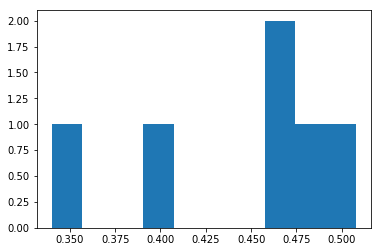

In [11]:
import scipy.stats as stats
print("Accuracy list: ")
vec_acc.sort()
print(vec_acc)

desc = stats.describe(vec_acc)

std = np.sqrt(desc.variance)
print('The 95%% confidence interval of accuracy is [%.2f, %.2f]'%(desc.mean-2.7*std, desc.mean+2.7*std) )

print("The mean and std are %.2f +/- %.2f" %(desc.mean, np.sqrt(desc.variance)))
plt.hist(vec_acc); 

# Training

In [12]:
def _init_fn(worker_id):
    np.random.seed(1 + worker_id)
    
train_data = SceneDataset(X_train_p, y_train, transform=train_tf)
test_data = SceneDataset(X_test_p, y_test, transform=test_tf)

trainloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True, num_workers=4, worker_init_fn=_init_fn)
testloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=True, num_workers=4, worker_init_fn=_init_fn)

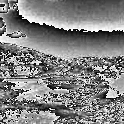

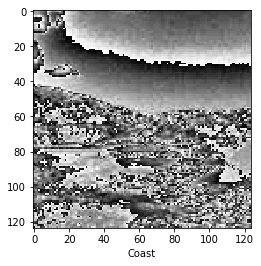

In [13]:
train_data.show_item(1)

In [14]:
net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

# num_epoch = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
pbar = tqdm(range(1, num_epoch+1))

cuda:0


In [15]:
set_seed(SEED+4)
loss_vec = train(net, criterion, optimizer, trainloader, device, num_epoch, print_every, pbar)

[1/100] Loss = 2.60
[2/100] Loss = 2.42
[3/100] Loss = 2.27
[4/100] Loss = 2.12
[5/100] Loss = 2.08
[6/100] Loss = 1.96
[7/100] Loss = 2.02
[8/100] Loss = 1.94
[9/100] Loss = 1.89
[10/100] Loss = 1.84
[11/100] Loss = 1.83
[12/100] Loss = 1.80
[13/100] Loss = 1.72
[14/100] Loss = 1.71
[15/100] Loss = 1.69
[16/100] Loss = 1.67
[17/100] Loss = 1.65
[18/100] Loss = 1.66
[19/100] Loss = 1.69
[20/100] Loss = 1.63
[21/100] Loss = 1.64
[22/100] Loss = 1.60
[23/100] Loss = 1.64
[24/100] Loss = 1.63
[25/100] Loss = 1.68
[26/100] Loss = 1.59
[27/100] Loss = 1.56
[28/100] Loss = 1.62
[29/100] Loss = 1.54
[30/100] Loss = 1.54
[31/100] Loss = 1.55
[32/100] Loss = 1.57
[33/100] Loss = 1.48
[34/100] Loss = 1.53
[35/100] Loss = 1.59
[36/100] Loss = 1.52
[37/100] Loss = 1.50
[38/100] Loss = 1.48
[39/100] Loss = 1.42
[40/100] Loss = 1.53
[41/100] Loss = 1.45
[42/100] Loss = 1.47
[43/100] Loss = 1.49
[44/100] Loss = 1.48
[45/100] Loss = 1.43
[46/100] Loss = 1.44
[47/100] Loss = 1.52
[48/100] Loss = 1.45
[

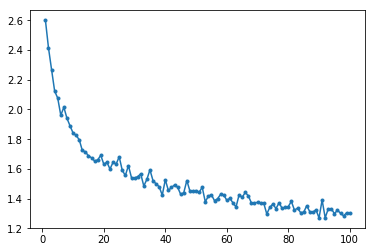

In [16]:
plt.plot(range(1, len(loss_vec)+1), loss_vec, '.-')

# Evaluation

In [17]:
# %%pixie_debugger -b evaluate_cm
set_seed(SEED+2)

def evaluate_cm(net, dataloader, classNames, device): 
    y_true, y_hat = predict(net, dataloader, device)
    acc =  float((y_hat == y_true).sum())/len(y_true)
    plot_confusion_matrix(y_true, y_hat, classNames)
    print("The accuracy is %.2f" % acc)

The accuracy is 0.45


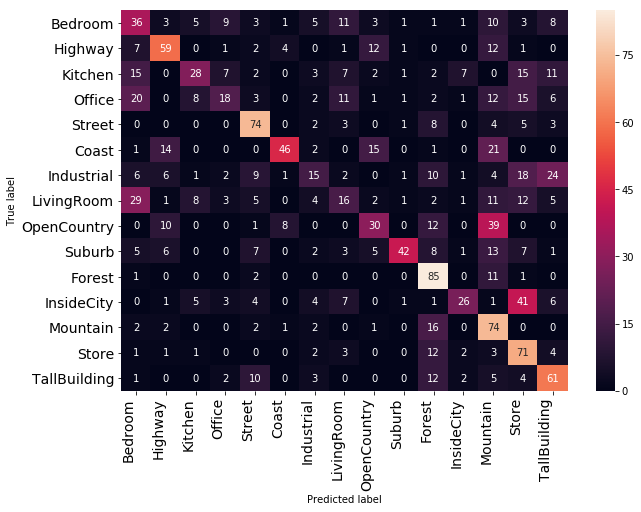

In [18]:
evaluate_cm(net, trainloader, classNames, device)

The accuracy is 0.45


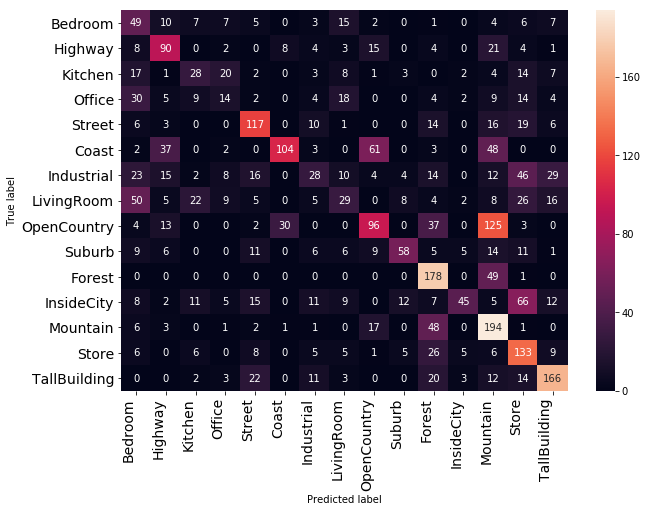

In [19]:
evaluate_cm(net, testloader, classNames, device)